In [1]:
!nvidia-smi

Fri Feb 11 07:41:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt 

import numpy as np

folders = {
    'train_x' : os.path.join('train', 'membrane_x'),
    'train_y' : os.path.join('train', 'membrane_y'),
    'test_x' : os.path.join('test', 'membrane_x'),
    'test_y' : os.path.join('test', 'membrane_y')
}


train_x = np.zeros((30, 256, 256,1), dtype=np.float32)
train_y = np.zeros((30, 256, 256,1), dtype=np.float32)
filled_images = 0


for i, eachImage in enumerate(os.listdir(folders['train_x'])):
    img = cv2.imread(os.path.join(folders['train_x'], eachImage),cv2.THRESH_BINARY)
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_NEAREST)
    img = img.reshape((256,256,1))
    img = img / 255
    #img[img > 0.5] = 1.0
    #img[img <= 0.5] = 0.0
    train_x[i] = img
    
    mask = cv2.imread(os.path.join(folders['train_y'], str(i)+'_predict.png'), cv2.THRESH_BINARY)
    mask = cv2.resize(mask, (256,256))
    mask = mask.reshape((256,256,1))
    mask = mask/255
    mask[mask > 0.5] = 1.0
    mask[mask <= 0.5] = 0.0
    train_y[i] = mask
    filled_images+=1

In [5]:
#from numpy.lib.twodim_base import mask_indices
test_x = np.zeros((5, 256, 256, 1), dtype=np.float32)
test_y = np.zeros((5, 256, 256, 1), dtype=np.float32)

for i, eachImage in enumerate(os.listdir(folders['test_x'])):
    img = cv2.imread(os.path.join(folders['test_x'], eachImage),cv2.THRESH_BINARY)
    img = cv2.resize(img, (256,256))
    img = img.reshape((256, 256, 1))
    img = img / 255
    test_x[i] = img
    
    mask = cv2.imread(os.path.join(folders['test_y'], str(25 + i)+'_predict.png'),cv2.THRESH_BINARY)
    mask = cv2.resize(mask, (256,256))
    mask = mask.reshape((256, 256, 1))
    mask = mask/255
    test_y[i] = mask

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_generator.flow(
    train_x,
    train_y,
    shuffle=True,
    batch_size=2
)

In [7]:
inputs = tf.keras.layers.Input(shape=(256, 256, 1))

c0 = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(inputs)
c1 = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(c0)  # This layer for concatenating in the expansive part
#c1 = tf.keras.layers.Dropout(0.1)(c1)
c2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(c1)

c3 = tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(c2)
c4 = tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(c3)  # This layer for concatenating in the expansive part
#c4 = tf.keras.layers.Dropout(0.1)(c4)
c5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(c4)

c6 = tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3, padding='same')(c5)
c7 = tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3, padding='same')(c6)  # This layer for concatenating in the expansive part
#c7 = tf.keras.layers.Dropout(0.1)(c7)
c8 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(c7)

c9 = tf.keras.layers.Conv2D(512, activation='relu', kernel_size=3, padding='same')(c8)
c10 = tf.keras.layers.Conv2D(512, activation='relu', kernel_size=3, padding='same')(c9)  # This layer for concatenating in the expansive part
#c10 = tf.keras.layers.Dropout(0.1)(c10)
c11 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(c10)

c12 = tf.keras.layers.Conv2D(1024, activation='relu', kernel_size=3, padding='same')(c11)
c13 = tf.keras.layers.Conv2D(1024, activation='relu', kernel_size=3, padding='same')(c12)
c13 = tf.keras.layers.Dropout(0.5)(c13)

# We will now start the second part of the U - expansive part
t01 = tf.keras.layers.Conv2DTranspose(512, kernel_size=2, strides=(2, 2), activation='relu', padding='same')(c13)
concat01 = tf.keras.layers.concatenate([t01, c10])
c14 = tf.keras.layers.Conv2D(512, activation='relu', kernel_size=3, padding='same')(concat01)
c15 = tf.keras.layers.Conv2D(512, activation='relu', kernel_size=3, padding='same')(c14)

t02 = tf.keras.layers.Conv2DTranspose(256, kernel_size=2, strides=(2, 2), activation='relu', padding='same')(c15)
concat02 = tf.keras.layers.concatenate([t02, c7])
c16 = tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3, padding='same')(concat02)
c17 = tf.keras.layers.Conv2D(256, activation='relu', kernel_size=3, padding='same')(c16)

t03 = tf.keras.layers.Conv2DTranspose(128, kernel_size=2, strides=(2, 2), activation='relu',padding='same')(c17)
concat03 = tf.keras.layers.concatenate([t03, c4])
c18 = tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(concat03)
c19 = tf.keras.layers.Conv2D(128, activation='relu', kernel_size=3, padding='same')(c18)

t04 = tf.keras.layers.Conv2DTranspose(64, kernel_size=2, strides=(2, 2), activation='relu', padding='same')(c19)
concat04 = tf.keras.layers.concatenate([t04, c1])
c20 = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(concat04)
c21 = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3, padding='same')(c20)

outputs = tf.keras.layers.Conv2D(1, kernel_size=1, activation='sigmoid')(c21)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="u-netmodel")

In [8]:
model.build(input_shape=(256, 256,1))
model.compile(optimizer=tf.keras.optimizers.Adam(),# Adam(learning_rate=1e-2),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
result = model.fit(
    train_generator,
    epochs=5,
    steps_per_epoch=len(train_x)//2)

Epoch 1/5
15/15 [==============================] - 23s 403ms/step - loss: 0.6321 - accuracy: 0.6619
Epoch 2/5
15/15 [==============================] - 6s 401ms/step - loss: 0.5511 - accuracy: 0.7613
Epoch 3/5
15/15 [==============================] - 6s 404ms/step - loss: 0.5450 - accuracy: 0.8281
Epoch 4/5
15/15 [==============================] - 6s 400ms/step - loss: 0.5266 - accuracy: 0.8286
Epoch 5/5
15/15 [==============================] - 6s 402ms/step - loss: 0.4410 - accuracy: 0.8280


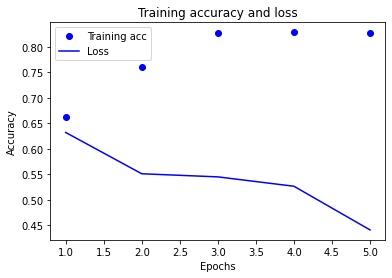

In [12]:
ac = result.history['accuracy']
loss = result.history['loss']

plt.plot(range(1, len(ac)+1), ac, 'bo', label='Training acc')
plt.plot(range(1, len(loss)+1), loss, 'b', label='Loss')
       
plt.title('Training accuracy and loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predicted_result = model.predict(test_x)

plt.title('Original')
plt.imshow(test_x[2, :,:,0], cmap='binary')
plt.show()

plt.title('Mask')
plt.imshow(test_y[2,:,:,0], cmap='binary')
plt.show()

plt.title('Predicted')
plt.imshow(predicted_result[2,:,:,0], cmap='gist_gray')
plt.show()
'''
plt.title('Predicted')
plt.imshow(np.array(predicted_result[2], dtype=np.uint8) .reshape((256,256)), cmap='binary')
plt.show()'''